In [1]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from tvb.simulator.lab import *
from tvb_inversion.base.observation_models import linear
from tvb_inversion.pymc3.prior import Pymc3Prior
from tvb_inversion.pymc3.stats_model import Pymc3Model
from tvb_inversion.pymc3.inference import EstimatorPYMC
from tvb_inversion.pymc3.stats_model_builder import StochasticPymc3ModelBuilder
from tvb_inversion.pymc3.plot import plot_posterior_samples

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/erichter/Documents/Uni/Charite/tvb-backend/tvb-root/tvb_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
#conn = connectivity.Connectivity.from_file()
conn = connectivity.Connectivity()
conn.weights = np.array([[0., 2.], [2., 0.]])
conn.region_labels = np.array(["R1", "R2"])
conn.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
conn.tract_lengths = np.array([[0., 2.5], [2.5, 0.]])
conn.configure()

sim = simulator.Simulator(
    model=models.oscillator.Generic2dOscillator(a=np.array([1.5])),
    connectivity=conn,
    coupling=coupling.Difference(),
    integrator=integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(
            nsig=np.array([1e-4]),
            noise_seed=42
        )
    ),
    monitors=[monitors.Raw()],
    simulation_length = 250
)

In [3]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 9680b584-a310-4d57-9d71-5fa130b6f741
coupling,Difference gid: 82a78bd3-367b-4e25-91c9-1886eb319c33
gid,UUID('0816804c-81ce-4287-8eb4-c0708db27188')
initial_conditions,None
integrator,HeunStochastic gid: 5bcd4745-b2cd-41ab-91e3-8aa8a90346e4
model,Generic2dOscillator gid: b5bac0cf-872d-4cb6-8e9a-b320fbf93f9a
monitors,[]
simulation_length,250.0


In [4]:
sim.initial_conditions = np.zeros((conn.horizon, sim.model.nvar, conn.number_of_regions, 1))

In [5]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 9680b584-a310-4d57-9d71-5fa130b6f741
coupling,Difference gid: 82a78bd3-367b-4e25-91c9-1886eb319c33
gid,UUID('0816804c-81ce-4287-8eb4-c0708db27188')
"initial_conditions [min, median, max]","[0, 0, 0]"
initial_conditions dtype,float64
initial_conditions shape,"(2, 2, 2, 1)"
integrator,HeunStochastic gid: 5bcd4745-b2cd-41ab-91e3-8aa8a90346e4
model,Generic2dOscillator gid: b5bac0cf-872d-4cb6-8e9a-b320fbf93f9a


In [6]:
(t, X), = sim.run()

In [7]:
X.shape

(250, 2, 2, 1)

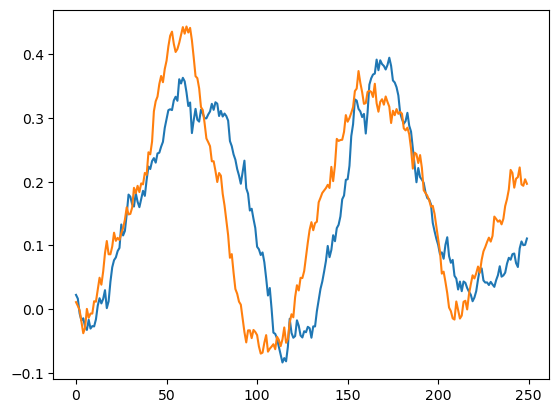

In [8]:
plt.plot(X[:, 0, :, 0]);

In [14]:
def_std = 0.1

model = pm.Model()
with model:
    model_a_star = pm.Normal(name="model_a_star", mu=0.0, sd=1.0, shape=sim.model.a.shape)
    model_a = pm.Deterministic(name="model_a", var=sim.model.a * (1.0 + def_std * model_a_star))
    
    coupling_a_star = pm.Normal(name="coupling_a_star", mu=0.0, sd=1.0)
    coupling_a = pm.Deterministic(name="coupling_a", 
                                  var=sim.coupling.a[0].item() * (1.0 + def_std * coupling_a_star))
    
    x_init_star = pm.Normal(name="x_init_star", mu=0.0, sd=1.0, 
                            shape=sim.initial_conditions.shape[:-1])
    x_init = pm.Deterministic(name="x_init", 
                              var=sim.initial_conditions[:, :, :, 0] * (1.0 + def_std*x_init_star))
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    nsig_star = BoundedNormal(name="nsig_star", mu=0.0, sd=1.0)
    nsig = pm.Deterministic(name="nsig", 
                            var=sim.integrator.noise.nsig[0].item() * (1.0 + def_std * nsig_star))
    
    dWt_star = pm.Normal(name="dWt_star", mu=0.0, sd=1.0, shape=X.shape[:-1])
    
    amplitude_star = pm.Normal(name="amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic(name="amplitude", var=1.0 * (1.0 + def_std * amplitude_star))

    offset_star = pm.Normal(name="offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic(name="offset", var=def_std * offset_star)
    
    observation_noise_star = pm.HalfNormal("observation_noise_star", sd=1.0)
    observation_noise = pm.Deterministic("observation_noise", var=def_std*observation_noise_star)
    

In [15]:
prior = Pymc3Prior(
    model=model,
    names=["model.a", "coupling.a", "x_init", "integrator.noise.nsig", "dWt_star", 
           "observation.model.amplitude", "observation.model.offset", "observation.noise"], 
    dist=[model_a, coupling_a, x_init, nsig, dWt_star, 
          amplitude, offset, observation_noise]
)

In [16]:
model_builder = StochasticPymc3ModelBuilder(sim=sim, params=prior, 
                                            observation_fun=linear, observation=X[:, :, :, 0])

In [17]:
model_builder.compose_model()

In [18]:
pymc_model = model_builder.build()

In [19]:
pymc_model.model

In [20]:
pymc_estimator = EstimatorPYMC(stats_model=pymc_model)

In [21]:
draws = 500
tune = 500
cores = 2

In [ ]:
inference_data = pymc_estimator.run_inference(
    draws=draws, tune=tune, cores=cores, target_accept=0.9, max_treedepth=15)

/Users/erichter/opt/anaconda3/envs/tvb-inv-env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...


07-12-2022 07:24:50 - INFO - pymc3 - Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


07-12-2022 07:24:50 - INFO - pymc3 - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


07-12-2022 07:25:01 - INFO - pymc3 - Multiprocess sampling (2 chains in 2 jobs)


NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, coupling_a_star, model_a_star]


07-12-2022 07:25:01 - INFO - pymc3 - NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, coupling_a_star, model_a_star]


In [ ]:
init_params = {
    "model_a": sim.model.a,
    "coupling_a": sim.coupling.a[0],
    "nsig": sim.integrator.noise.nsig[0],
    "observation_noise": 0.0,
    "amplitude": 1.0,
    "offset": 0.0
}
plot_posterior_samples(pymc_estimator.inference_data, init_params)

In [ ]:
init_params = {
    "model_a_star": 0.0,
    "coupling_a_star": 0.0,
    "nsig_star": 0.0,
    "observation_noise_star": 0.0,
    "amplitude_star": 0.0,
    "offset_star": 0.0
}
plot_posterior_samples(pymc_estimator.inference_data, init_params)

In [ ]:
posterior_x_obs = pymc_estimator.inference_data.posterior_predictive.x_obs.values.reshape(
    (cores*draws, *X.shape[:-1]))

In [ ]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1, 0], label="W_observed")
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [ ]:
pymc_estimator.inference_summary.loc[
    pymc_estimator.inference_summary.index.str.contains("model_a_star")].describe()

In [ ]:
pymc_estimator.inference_summary.loc[
    ["model_a_star", "coupling_a_star", "nsig_star", 
     "amplitude_star", "offset_star", "observation_noise_star"]]

In [ ]:
pymc_estimator.inference_summary.loc[
    pymc_estimator.inference_summary.index.str.contains("x_init_star")].describe()

In [ ]:
pymc_estimator.inference_summary.loc[
    pymc_estimator.inference_summary.index.str.contains("dWt_star")].describe()

In [ ]:
pymc_estimator.inference_data.to_netcdf(filename="pymc3_data/test1.nc", compress=False)